<a href="https://colab.research.google.com/github/BogdanTurbal/dublicate_image_detection_CSCHack/blob/main/autoencoder%2Bdiscriminator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline
import pandas as pd
import pyarrow.parquet as pq
import os
from tqdm import tqdm
from skimage.transform import resize
import json
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import shutil
from tensorflow.keras import backend as K

# Loading and unzipping

In [ ]:
!cp "/content/drive/MyDrive/competition/train.csv" "/content/train.csv"
!cp "/content/drive/MyDrive/competition/test-data.csv" "/content/test-data.csv"

In [ ]:
!unzip /content/drive/MyDrive/competition/train_color_m255_v_1_0.zip -d /content/

In [ ]:
import tensorflow as tf
import pandas as pd

# Load CSV file into a pandas DataFrame
import tensorflow as tf
batch_size=64

def del_pad_sides(img, edg_val=245/255):
    arrt = tf.reduce_mean(img, axis=[0, -1])
    arrt = tf.less_equal(arrt, edg_val)
    first_true_left = tf.argmax(tf.cast(arrt, tf.float32))
    first_true_right = tf.cast(tf.shape(arrt)[0], tf.int64) - tf.argmax(tf.cast(tf.reverse(arrt, axis=[0]), tf.float32)) - 1
    return img[:, first_true_left:first_true_right]

def del_pad_ups(img, edg_val=245/255):
    arrt = tf.reduce_mean(img, axis=[1, -1])
    arrt = tf.less_equal(arrt, edg_val)
    first_true_left = tf.argmax(tf.cast(arrt, tf.float32))
    first_true_right = tf.cast(tf.shape(arrt)[0], tf.int64) - tf.argmax(tf.cast(tf.reverse(arrt, axis=[0]), tf.float32)) - 1
    return img[first_true_left:first_true_right, :]

def del_pad(img, edg_val=245/255):
    return del_pad_sides(del_pad_ups(img, edg_val=edg_val), edg_val=edg_val)

def resize_and_rescale(image, max_shape=128):
    img = del_pad(image, edg_val=245/255)
    img = tf.image.resize(img, (max_shape, max_shape))
    return img

def pad_image(image):
    shape = tf.shape(image)

    image = del_pad_sides(del_pad_ups(image))

    padded_image = tf.image.resize_with_crop_or_pad(image, 256, 256)

    white_pixels = tf.ones([256, 256, shape[-1]], tf.float32)
    mask = tf.image.resize(tf.ones_like(image), [256, 256])
    padded_image = padded_image * mask + white_pixels * (1 - mask)

    return padded_image


def process_path(file_path1, file_path2, label):
    img1 = tf.io.read_file('/content/content/train/new_images/' + file_path1)
    img2 = tf.io.read_file('/content/content/train/new_images/' + file_path2)

    img1 = tf.image.decode_jpeg(img1, channels=3)
    img2 = tf.image.decode_jpeg(img2, channels=3)

    img1 = resize_and_rescale(img1 / 255)
    img2 = resize_and_rescale(img2 / 255)

    return (img1, img2), label

def create_dataset(df):
    ds = tf.data.Dataset.from_tensor_slices((df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2]))

    ds = ds.map(process_path).batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds

In [ ]:
dir_path='/content/content/train/new_images'

In [ ]:
dir_path='/content/content/train/new_images'
def image_exists(row):
    image1_exists = os.path.isfile(os.path.join(dir_path, os.path.basename(row['image_url1'])))
    image2_exists = os.path.isfile(os.path.join(dir_path, os.path.basename(row['image_url2'])))
    return image1_exists and image2_exists

In [ ]:
df = pd.read_csv('/content/train.csv')
mask = df.apply(image_exists, axis=1)
df = df[mask]

df["image_url1"] = df["image_url1"].apply(lambda x: x.split('/')[-1])
df["image_url2"] = df["image_url2"].apply(lambda x: x.split('/')[-1])

train_df = df.iloc[:int(len(df) * 0.9), :]
test_df = df.iloc[int(len(df) * 0.9):, :]

<ipython-input-8-8b9c65049429>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["image_url1"] = df["image_url1"].apply(lambda x: x.split('/')[-1])
<ipython-input-8-8b9c65049429>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["image_url2"] = df["image_url2"].apply(lambda x: x.split('/')[-1])


In [ ]:
train_ds = create_dataset(train_df)
test_ds = create_dataset(test_df)

In [ ]:
batch = next(iter(test_ds))

# Define model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

import tensorflow as tf
from tensorflow.keras import layers

class ConvLayer(layers.Layer):
    def __init__(self, filters=256, kernel_size=(3, 3), padding='same', alpha=0.2, pool_size=(2, 2), pool=True, **kwargs):
        super(ConvLayer, self).__init__(**kwargs)
        self.conv = layers.Conv2D(filters, kernel_size, padding=padding)
        self.leaky_relu = layers.LeakyReLU(alpha=alpha)
        self.batch_norm = layers.BatchNormalization()
        self.max_pool = layers.MaxPool2D(pool_size)
        self.pool = pool

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.leaky_relu(x)
        x = self.batch_norm(x)
        if self.pool:
          x = self.max_pool(x)
        return x

class CustomConvTransposeLayer(layers.Layer):
    def __init__(self, filters=16, kernel_size=3, strides=2, padding='same', alpha=0.2, **kwargs):
        super(CustomConvTransposeLayer, self).__init__(**kwargs)
        self.conv_transpose = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
        self.batch_norm = layers.BatchNormalization()
        self.leaky_relu = layers.LeakyReLU(alpha=alpha)

    def call(self, inputs):
        x = self.conv_transpose(inputs)
        x = self.batch_norm(x)
        return self.leaky_relu(x)


class ConvAutoencoderN(tf.keras.Model):
    def __init__(self):
        super(ConvAutoencoderN, self).__init__()
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(128, 128, 3)),
            ConvLayer(filters=256),
            ConvLayer(filters=128),
            ConvLayer(filters=64),
            ConvLayer(filters=64),
            ConvLayer(filters=64, pool=False)])
            #layers.MaxPool2D((2, 2)),])

        # Decoder
        self.decoder = tf.keras.Sequential([
            CustomConvTransposeLayer(filters=64, strides=1),
            CustomConvTransposeLayer(filters=64, strides=2),
            CustomConvTransposeLayer(filters=64, strides=2),
            CustomConvTransposeLayer(filters=128, strides=2),
            CustomConvTransposeLayer(filters=256, strides=2),
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = tf.reduce_sum(tf.keras.losses.MSE(data, self.call(data)))

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        return {
            'loss': loss
        }
    def test_step(self, data):
        loss = tf.reduce_sum(tf.keras.losses.MSE(data, self.call(data)))
        return {
            'loss': loss
        }

In [ ]:
batch[0][0][0].shape

TensorShape([128, 128, 3])

In [ ]:
autoencoder = ConvAutoencoderN()
  #model.build((None, 256, 256, 6))
autoencoder.compile(optimizer=tf.keras.optimizers.Adam())
_ = autoencoder(batch[0][0][0][None])
autoencoder.load_weights('/content/mod_encod_2_0 (1).h5')

In [ ]:
autoencoder.layers

In [ ]:
encoder = autoencoder.layers[0]
encoder.trainable=False

In [ ]:
encoder(batch[0][0][0][None]).shape

TensorShape([1, 8, 8, 64])

In [ ]:
import tensorflow as tf

class SIMSiam(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.enc = encoder

        #self.dense0 = layers.Dense(32, activation="relu")
        self.dense_def1 = layers.Dense(32, activation="relu")
        #self.dense_def2 = layers.Dense(32, activation="relu")
        self.dense1= layers.Dense(16, activation="relu")
        #self.dense2= layers.Dense(16, activation="relu")
        self.dense3= layers.Dense(1, activation="sigmoid")

        self.augm_1_0 = tf.keras.layers.RandomContrast(0.2)
        self.augm_1_1 = tf.keras.layers.RandomBrightness(0.1, value_range=[0.0, 1.0])

        self.augm_2_0 = tf.keras.layers.RandomContrast(0.2)
        self.augm_2_1 = tf.keras.layers.RandomBrightness(0.1, value_range=[0.0, 1.0])

    def call(self, inputs, training=False):
        img1 = inputs[0]
        img2 = inputs[1]
        img1 = self.dense_def1(self.enc(img1))
        img2 = self.dense_def1(self.enc(img2))
        #print(img1.shape)
        res = tf.math.square((img1-img2))
        res = tf.reduce_mean(res, axis=[-2, -3])
        #print(res.shape)

        #x = self.dense0(x)
        x = self.dense1(res)
        #x = self.dense2(x)
        x = self.dense3(x)
        #print(x.shape)
        return x

# Define metrics


In [ ]:
def p_metric(y_true, y_pred):
    # Converting the sigmoid output to binary by thresholding at 0.5
    y_pred_binary = tf.cast(K.round(y_pred), tf.int32)
    # Calculate True Positives, False Positives, and False Negatives
    y_true = tf.cast(y_true, tf.int32)
    tp = K.sum(K.cast((y_true * y_pred_binary), 'float'))
    fp = K.sum(K.cast((K.clip((1 - y_true) * y_pred_binary, 0, 1)), 'float'))
    fn = K.sum(K.cast((K.clip(y_true * (1 - y_pred_binary), 0, 1)), 'float'))

    # Calculate Precision and Recall
    p = tp / (tp + fp + K.epsilon())
    return p

In [ ]:
def r_metric(y_true, y_pred):
    # Converting the sigmoid output to binary by thresholding at 0.5
    y_pred_binary = tf.cast(K.round(y_pred), tf.int32)
    # Calculate True Positives, False Positives, and False Negatives
    y_true = tf.cast(y_true, tf.int32)
    tp = K.sum(K.cast((y_true * y_pred_binary), 'float'))
    fp = K.sum(K.cast((K.clip((1 - y_true) * y_pred_binary, 0, 1)), 'float'))
    fn = K.sum(K.cast((K.clip(y_true * (1 - y_pred_binary), 0, 1)), 'float'))

    # Calculate Precision and Recall
    r = tp / (tp + fn + K.epsilon())
    return r

In [ ]:
def f1_metric(y_true, y_pred):
    # Converting the sigmoid output to binary by thresholding at 0.5
    y_pred_binary = tf.cast(K.round(y_pred), tf.int32)
    # Calculate True Positives, False Positives, and False Negatives
    y_true = tf.cast(y_true, tf.int32)
    tp = K.sum(K.cast((y_true * y_pred_binary), 'float'))
    fp = K.sum(K.cast((K.clip((1 - y_true) * y_pred_binary, 0, 1)), 'float'))
    fn = K.sum(K.cast((K.clip(y_true * (1 - y_pred_binary), 0, 1)), 'float'))

    # Calculate Precision and Recall
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    # Calculate F1 score
    f1 = 2 * p * r / (p + r + K.epsilon())

    return f1

In [ ]:
def f1_score(y_true, y_pred):
    # just in case of hipster activation at the final layer
    y_pred = K.round(y_pred)

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [ ]:
def cumul_f1_metric(y_true, y_pred):
    f1 = f1_metric(y_true, y_pred)
    f0 = f1_metric(1 - y_true, 1 - y_pred)
    return (f0 + f1) /  2

In [ ]:
from collections import Counter
Counter(train_df.is_same.values)

Counter({0: 55465, 1: 26082})

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
pos = 26082
neg = 55465
total = pos + neg
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.74
Weight for class 1: 1.56


# Initialize

In [ ]:
model = SIMSiam()
  #model.build((None, 256, 256, 6))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                           tf.keras.metrics.Precision(),
                           p_metric,
                           r_metric,
                           f1_score,
                          #tf.keras.metrics.Recall(name='recall'),
                          cumul_f1_metric])
_ = model(batch[0])
model.load_weights('/content/submit2.h5')

In [ ]:
model.summary()

Model: "sim_siam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 8, 8, 64)          452160    
                                                                 
 dense (Dense)               multiple                  2080      
                                                                 
 dense_1 (Dense)             multiple                  528       
                                                                 
 dense_2 (Dense)             multiple                  17        
                                                                 
 random_contrast (RandomCont  multiple                 0 (unused)
 rast)                                                           
                                                                 
 random_brightness (RandomBr  multiple                 0 (unused)
 ightness)                                                

In [ ]:
imgs = []
for ex in tqdm(test_ds.take(1)):
  #print(ex[0][0].shape)
  prd = model(ex[0])
  #print(prd.shape)
  prs = prd
  res = tf.cast((prd >= 0.5), tf.int32)
  #print(res.shape)
  for i in range(prd.shape[0]):
    imgs.append(((ex[0][0][i], ex[0][1][i]), ex[1][i], prs[i]))

100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


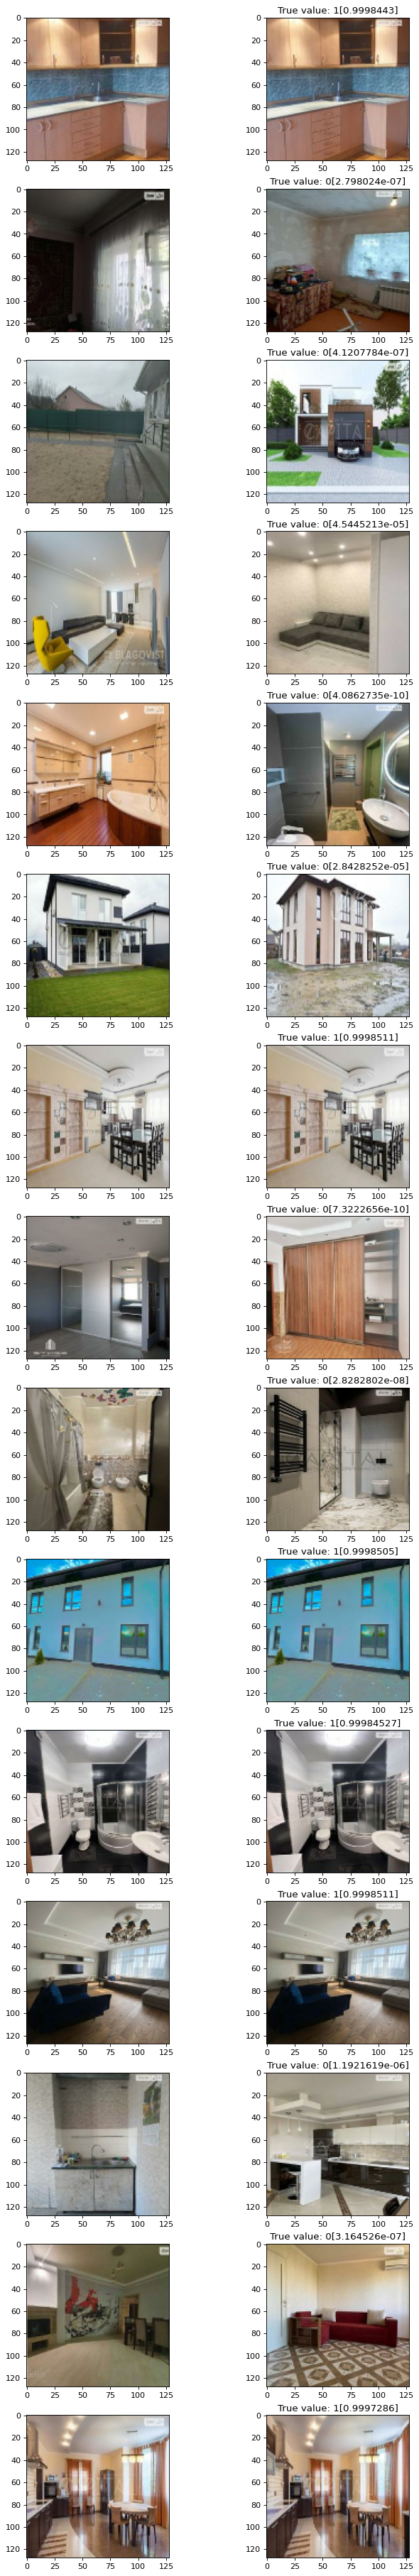

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(10, 250), dpi=80)
for i, erg in enumerate(imgs[:15]):
  plt.subplot(len(imgs), 2, i * 2 + 1)
  plt.imshow(erg[0][0])
  plt.subplot(len(imgs), 2, i * 2 + 2)
  plt.imshow(erg[0][1])
  plt.title(str(i) + " " + str(tf.get_static_value(erg[1])) + str(tf.get_static_value(erg[2])))

In [ ]:
checkpoint_path = "training3/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 64

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    #verbose=1,
    save_weights_only=True,
    save_freq=5*batch_size)

# Training


In [ ]:
model.fit(train_ds, validation_data=test_ds, callbacks=[cp_callback], epochs=40,
              class_weight=class_weight)

Epoch 1/40
1274/1274 [==============================] - 218s 169ms/step - loss: 0.0029 - accuracy: 0.9995 - precision_6: 0.9989 - p_metric: 0.9989 - r_metric: 0.9997 - f1_score: 0.9993 - cum_f1_metric: 0.9994 - val_loss: 0.0037 - val_accuracy: 0.9991 - val_precision_6: 0.9986 - val_p_metric: 0.9986 - val_r_metric: 0.9987 - val_f1_score: 0.9986 - val_cum_f1_metric: 0.9990
Epoch 2/40
1274/1274 [==============================] - 214s 168ms/step - loss: 0.0028 - accuracy: 0.9996 - precision_6: 0.9989 - p_metric: 0.9989 - r_metric: 0.9998 - f1_score: 0.9994 - cum_f1_metric: 0.9995 - val_loss: 0.0036 - val_accuracy: 0.9992 - val_precision_6: 0.9986 - val_p_metric: 0.9986 - val_r_metric: 0.9990 - val_f1_score: 0.9988 - val_cum_f1_metric: 0.9991
Epoch 3/40
 250/1274 [====>.........................] - ETA: 2:34 - loss: 0.0029 - accuracy: 0.9996 - precision_6: 0.9994 - p_metric: 0.9994 - r_metric: 0.9995 - f1_score: 0.9994 - cum_f1_metric: 0.9996

KeyboardInterrupt: ignored

In [ ]:
model.fit(train_ds, validation_data=test_ds, callbacks=[], epochs=40,
              class_weight=class_weight)

Epoch 1/40
1274/1274 [==============================] - 90s 68ms/step - loss: 0.0029 - accuracy: 0.9995 - precision: 0.9989 - p_metric: 0.9989 - r_metric: 0.9997 - cum_f1_metric: 0.9994 - val_loss: 0.0037 - val_accuracy: 0.9991 - val_precision: 0.9986 - val_p_metric: 0.9986 - val_r_metric: 0.9987 - val_cum_f1_metric: 0.9990
Epoch 2/40
1274/1274 [==============================] - 86s 68ms/step - loss: 0.0028 - accuracy: 0.9996 - precision: 0.9989 - p_metric: 0.9989 - r_metric: 0.9998 - cum_f1_metric: 0.9995 - val_loss: 0.0036 - val_accuracy: 0.9992 - val_precision: 0.9986 - val_p_metric: 0.9986 - val_r_metric: 0.9990 - val_cum_f1_metric: 0.9991
Epoch 3/40
1274/1274 [==============================] - 88s 69ms/step - loss: 0.0027 - accuracy: 0.9996 - precision: 0.9989 - p_metric: 0.9989 - r_metric: 0.9999 - cum_f1_metric: 0.9995 - val_loss: 0.0036 - val_accuracy: 0.9993 - val_precision: 0.9986 - val_p_metric: 0.9986 - val_r_metric: 0.9993 - val_cum_f1_metric: 0.9992
Epoch 4/40
1274/1274 [

KeyboardInterrupt: ignored

In [ ]:
model.fit(train_ds, validation_data=test_ds, callbacks=[cp_callback], epochs=40,
              class_weight=class_weight)

Epoch 1/40
1274/1274 [==============================] - 89s 68ms/step - loss: 0.0036 - accuracy: 0.9994 - precision_2: 0.9984 - p_metric: 0.9985 - r_metric: 0.9996 - cum_f1_metric: 0.9993 - val_loss: 0.0044 - val_accuracy: 0.9992 - val_precision_2: 0.9982 - val_p_metric: 0.9981 - val_r_metric: 0.9993 - val_cum_f1_metric: 0.9991
Epoch 2/40
1274/1274 [==============================] - 87s 68ms/step - loss: 0.0033 - accuracy: 0.9994 - precision_2: 0.9985 - p_metric: 0.9985 - r_metric: 0.9996 - cum_f1_metric: 0.9993 - val_loss: 0.0035 - val_accuracy: 0.9992 - val_precision_2: 0.9982 - val_p_metric: 0.9981 - val_r_metric: 0.9993 - val_cum_f1_metric: 0.9991
Epoch 3/40
1274/1274 [==============================] - 86s 67ms/step - loss: 0.0033 - accuracy: 0.9994 - precision_2: 0.9985 - p_metric: 0.9985 - r_metric: 0.9996 - cum_f1_metric: 0.9993 - val_loss: 0.0035 - val_accuracy: 0.9992 - val_precision_2: 0.9982 - val_p_metric: 0.9981 - val_r_metric: 0.9993 - val_cum_f1_metric: 0.9991
Epoch 4/40

KeyboardInterrupt: ignored

In [ ]:
model.fit(train_ds, validation_data=test_ds, callbacks=[cp_callback], epochs=40,
              class_weight=class_weight)

Epoch 1/40
1274/1274 [==============================] - 88s 69ms/step - loss: 0.0023 - accuracy: 0.9996 - precision: 0.9990 - p_metric: 0.9990 - r_metric: 0.9999 - cum_f1_metric: 0.9996 - val_loss: 0.0035 - val_accuracy: 0.9992 - val_precision: 0.9986 - val_p_metric: 0.9986 - val_r_metric: 0.9988 - val_cum_f1_metric: 0.9990
Epoch 2/40
1274/1274 [==============================] - 86s 68ms/step - loss: 0.0022 - accuracy: 0.9996 - precision: 0.9990 - p_metric: 0.9990 - r_metric: 0.9999 - cum_f1_metric: 0.9996 - val_loss: 0.0032 - val_accuracy: 0.9993 - val_precision: 0.9989 - val_p_metric: 0.9989 - val_r_metric: 0.9988 - val_cum_f1_metric: 0.9992
Epoch 3/40
1274/1274 [==============================] - 86s 68ms/step - loss: 0.0021 - accuracy: 0.9997 - precision: 0.9990 - p_metric: 0.9990 - r_metric: 0.9999 - cum_f1_metric: 0.9996 - val_loss: 0.0032 - val_accuracy: 0.9993 - val_precision: 0.9989 - val_p_metric: 0.9989 - val_r_metric: 0.9988 - val_cum_f1_metric: 0.9992
Epoch 4/40
1274/1274 [

# Testing + Error analysis

In [ ]:
wrongs = []
for ex in tqdm(test_ds):
  #print(ex[0][0].shape)
  prd = model(ex[0])
  #print(prd.shape)
  prs = prd
  res = tf.cast((prd >= 0.5), tf.int32)
  #print(res.shape)
  for i in range(prd.shape[0]):
    if tf.get_static_value(res[i]) != tf.get_static_value(ex[1][i]):
      print('kak')
      wrongs.append(((ex[0][0][i], ex[0][1][i]), ex[1][i], prs[i]))

  6%|▋         | 9/141 [00:02<00:33,  3.99it/s]

kak


  9%|▉         | 13/141 [00:03<00:31,  4.06it/s]

kak


 42%|████▏     | 59/141 [00:14<00:20,  3.99it/s]

kak


 43%|████▎     | 61/141 [00:15<00:19,  4.01it/s]

kak


 45%|████▌     | 64/141 [00:16<00:19,  4.04it/s]

kak


 94%|█████████▍| 133/141 [00:33<00:01,  4.14it/s]

kak


100%|██████████| 141/141 [00:35<00:00,  4.00it/s]


In [ ]:
len(wrongs)

6

In [ ]:
model.save_weights('stable_v_1_0.h5')

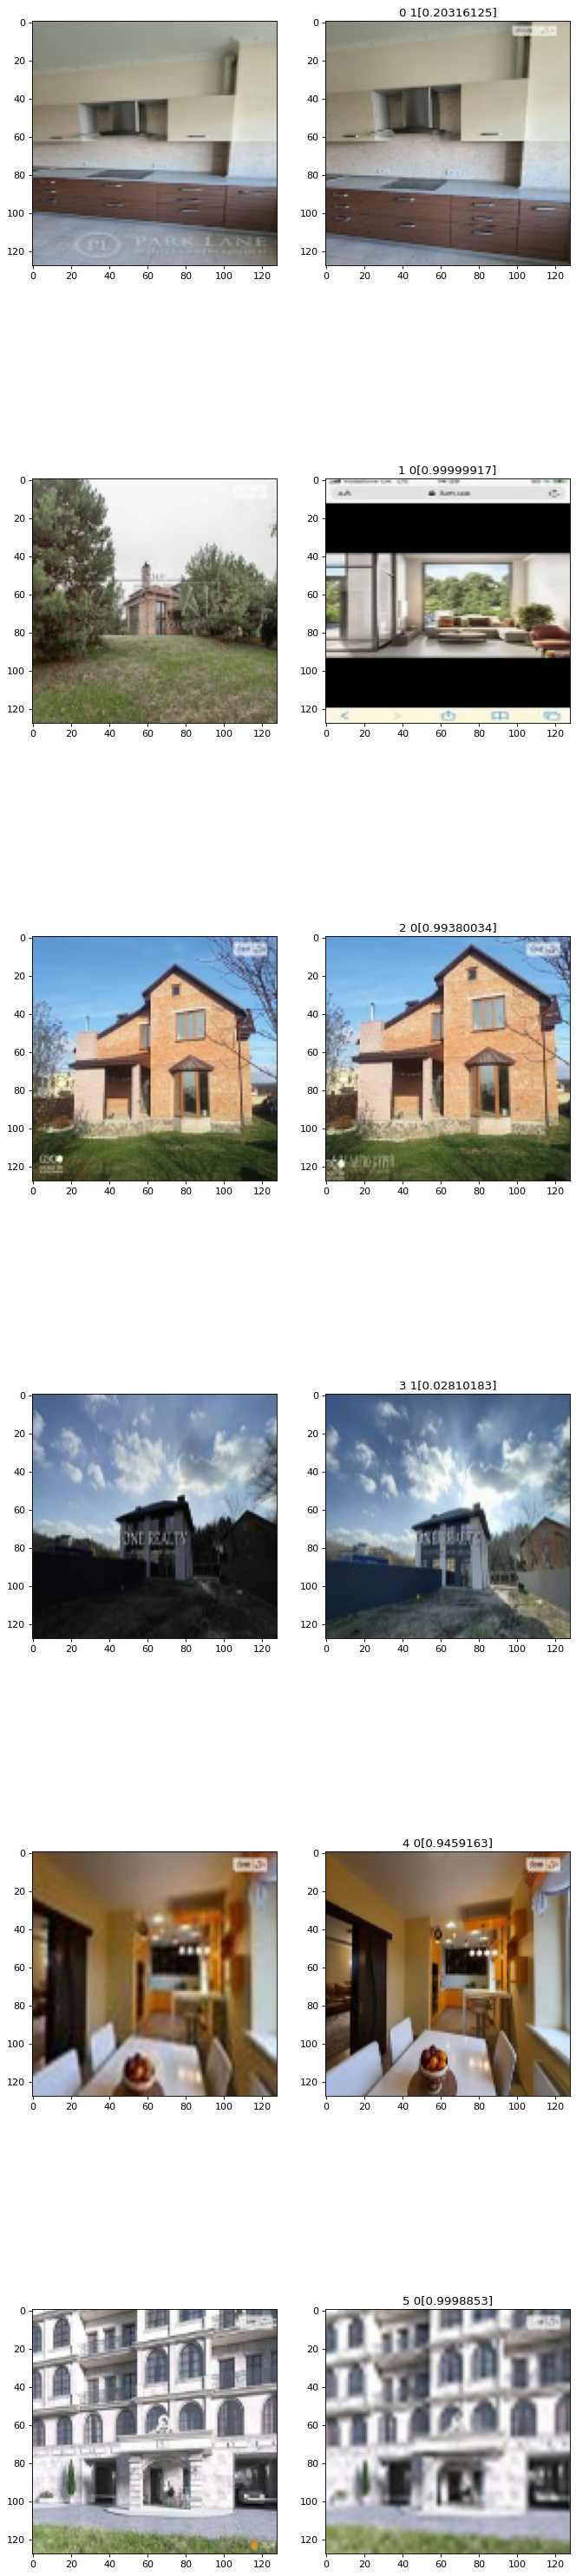

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(10, 50), dpi=80)
for i, erg in enumerate(wrongs):
  plt.subplot(len(wrongs), 2, i * 2 + 1)
  plt.imshow(erg[0][0])
  plt.subplot(len(wrongs), 2, i * 2 + 2)
  plt.imshow(erg[0][1])
  plt.title(str(i) + " " + str(tf.get_static_value(erg[1])) + str(tf.get_static_value(erg[2])))

In [ ]:
len(wrongs)

6

In [ ]:
!unzip /content/drive/MyDrive/competition/test_color_m255_v_1_0.zip -d /content/

In [ ]:
import tensorflow as tf
import pandas as pd

# Load CSV file into a pandas DataFrame
import tensorflow as tf
batch_size=64

def process_path(label, file_path1, file_path2):
    if file_path1 == 'none':
      return (tf.zeros((128, 128, 3)), tf.ones((128, 128, 3))), label
    img1 = tf.io.read_file('/content/content/test/new_test/' + file_path1)
    img2 = tf.io.read_file('/content/content/test/new_test/' + file_path2)

    img1 = tf.image.decode_jpeg(img1, channels=3)
    img2 = tf.image.decode_jpeg(img2, channels=3)

    img1 = resize_and_rescale(img1 / 255)
    img2 = resize_and_rescale(img2 / 255)

    return (img1, img2), label

def create_dataset(df):
    ds = tf.data.Dataset.from_tensor_slices((df.iloc[:, 0], df.iloc[:, 1], df.iloc[:, 2]))

    ds = ds.map(process_path).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds
#ds = create_dataset(df)

In [ ]:
dir_path='/content/content/test/new_test'
def image_exists(row):
    image1_exists = os.path.isfile(os.path.join(dir_path, os.path.basename(row['image_url1'])))
    image2_exists = os.path.isfile(os.path.join(dir_path, os.path.basename(row['image_url2'])))
    return not image1_exists or not image2_exists

In [ ]:
df2 = pd.read_csv('test-data.csv')
df2["image_url1"] = df2["image_url1"].apply(lambda x: x.split('/')[-1])
df2["image_url2"] = df2["image_url2"].apply(lambda x: x.split('/')[-1])

In [ ]:
mask = df2.apply(image_exists, axis=1)

In [ ]:
df2.loc[mask]

,ID,image_url1,image_url2
4226,4228,929195671.jpg,933005493.jpg
6669,6671,924977669.jpg,929236050.jpg
9493,9495,914008307.jpg,929195664.jpg
9810,9812,894942586.jpg,909695444.jpg
12781,12783,953656414.jpg,975179473.jpg


In [ ]:
df2.loc[mask, 'image_url1'] = 'none'

In [ ]:
test_res = create_dataset(df2)

In [ ]:
res_dc = {}
for ex in tqdm(test_res):
  #print(ex[0][0].shape)
  prd = model(ex[0])
  #print(prd.shape)
  res = tf.cast((prd >= 0.5), tf.int32)
  #print(res.shape)
  for i in range(prd.shape[0]):
    idx = ex[1][i].numpy()
    res_dc[idx] = int(res[i])
    #wrongs.append(((ex[0][0][i], ex[0][1][i]), ex[1][i]))

100%|██████████| 355/355 [00:44<00:00,  7.99it/s]


In [ ]:
import csv

# Assume this is your dictionary
data_dict = res_dc
# Sort your dictionary by keys (IDs)
sorted_data = dict(sorted(data_dict.items()))

# Open your csv file in write mode
with open('output.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # write the header
    writer.writerow(['ID', 'is_same'])

    # write the data
    for key, value in sorted_data.items():
        writer.writerow([key, value])
